# Sandbox for plotting spectra
### Olivia Cooper
### June 2022

In [1]:
# the basics

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import pandas as pd
import astropy
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
plt.style.use('../cooper-paper.mplstyle')

In [2]:
# change to object of interest

obj_name = 'c2020_pz_1.65_22.6_640174'

## mospy

In [3]:
# open 1D and 2D spectrum for an object

hdu2 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_eps.fits') # 2D spectrum
hdu1 = fits.open('../wmmc01/wmmc01_Y_'+obj_name+'_1D_00.fits') # 1D spectrum

In [4]:
# translate the 1D header data into a wavelength array

def make_1d_array(ext=0,hdu=hdu1):
    """
    object ext = 0
    sky ext = 1
    """
    im1d = hdu[ext] # point to the extension we want
    wavelength_start = im1d.header['CRVAL1'] # starting wavelength at first pixel
    wavelength_logdisp = im1d.header['CDELT1'] # delta wavelength per pixel
    num_wavelength = im1d.header['NAXIS1'] # length of data array

    pix_start = im1d.header['CRPIX1']
    pix_logdisp = im1d.header['CDELT1']
    num_pix = im1d.header['NAXIS1']

    pix = pix_start + np.arange(0, pix_logdisp*num_pix, pix_logdisp)
    wavelength = wavelength_start + np.arange(0, wavelength_logdisp*num_wavelength, wavelength_logdisp) # wavelength
    spec1d = im1d.data # spectrum
    
    return pix,wavelength,spec1d

In [5]:
pix_obj, wav_obj, spec1d_obj = make_1d_array(ext=0,hdu=hdu1) # object spectrum
pix_sky, wav_sky, spec1d_sky = make_1d_array(ext=1,hdu=hdu1) # sky spectrum

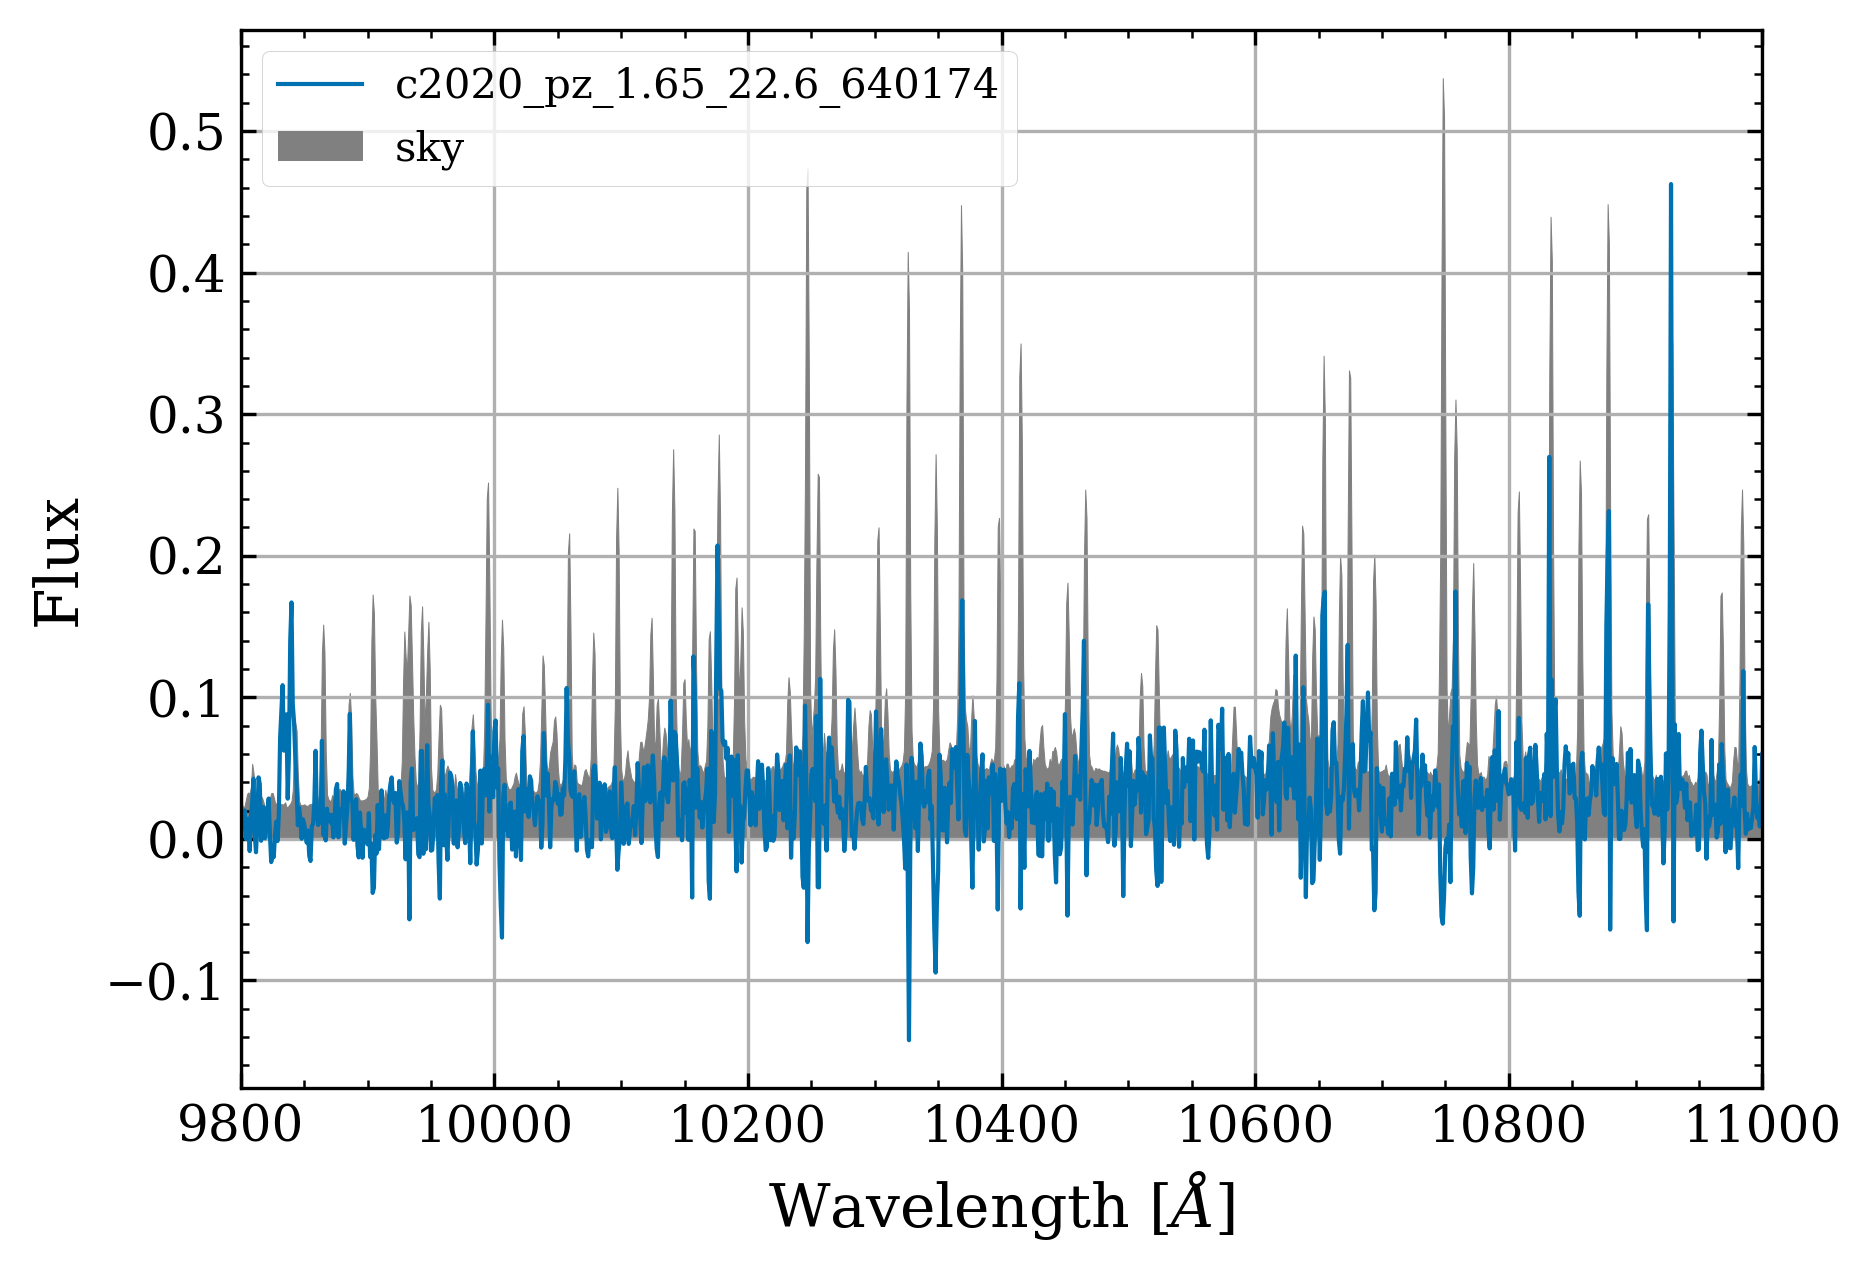

In [6]:
# plot the 1D spectra

plt.plot(wav_obj, spec1d_obj, lw=1, label=obj_name)
plt.fill_between(wav_sky, y1=spec1d_sky, y2=0, color='gray', label='sky')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.xlim(9800,11000) # change these to zoom in
plt.legend()

In [7]:
# list of spectral lines (originally from SDSS)
### shows the vacuum (rest) wavelength, the species, and the type of line

lines = pd.read_csv('../linelist.csv',delimiter=",",comment='#') # all lines
em = lines[lines['type']=='Emission'] # emission lines
ab = lines[lines['type']=='Absorption'] # absorption lines
sky = lines[lines['type']=='Sky'] # absorption lines

(0.0, 200.0)

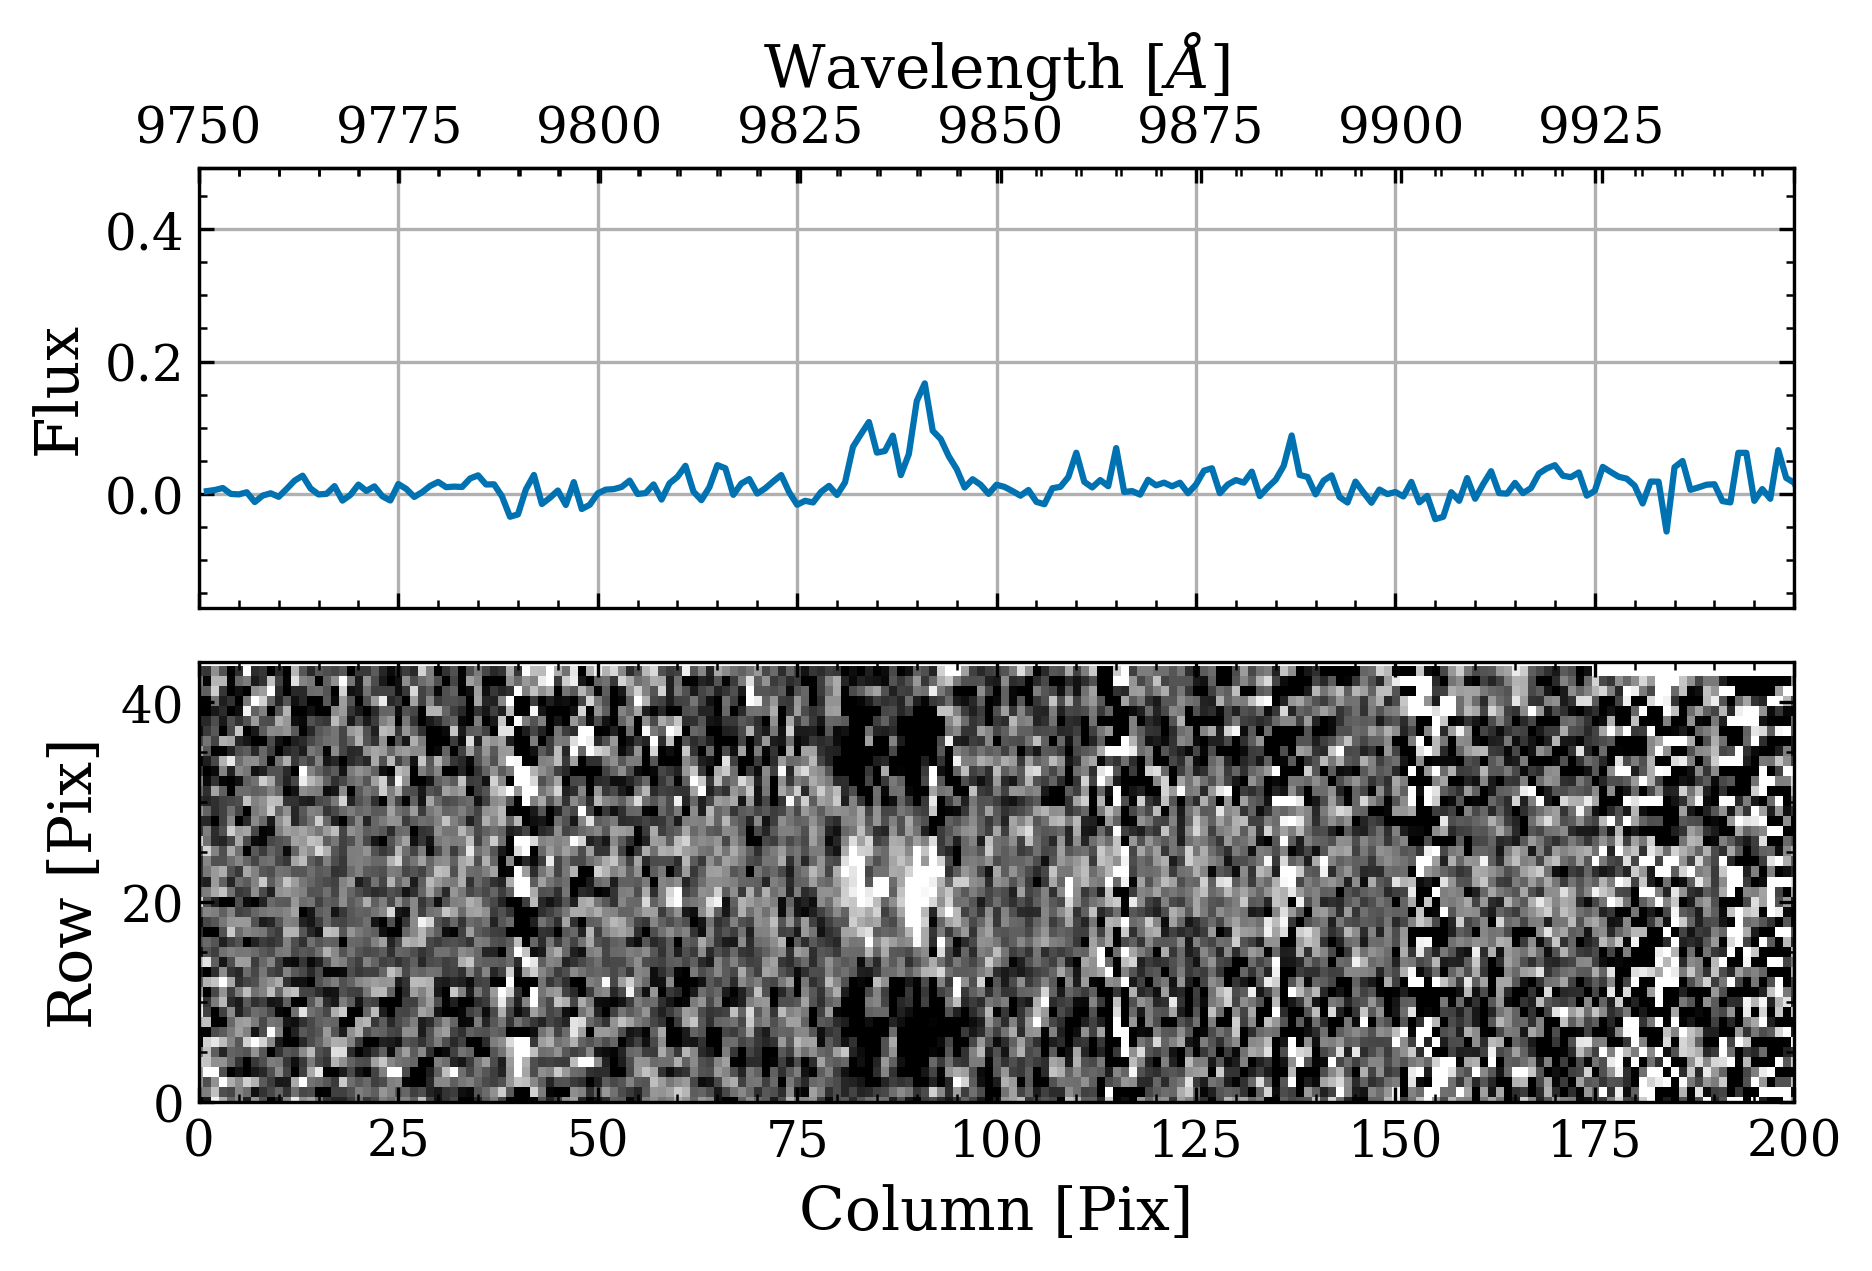

In [8]:
# plot the 1D/2D spectra

zguess = 1.638 ## adjust the redshift!

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

lower=-1; upper=2
sample = sigma_clip(hdu2[0].data) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(hdu2[0].data, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)

ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax1.set_ylabel(r'Flux')
ax2.grid(False)

ax1.plot(pix_obj,spec1d_obj)

def forward(x):
    return np.interp(x, pix_obj, wav_obj)


def inverse(x):
    return np.interp(x, wav_obj, pix_obj)

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')
line_pix = inverse(lines['lambda'])

ax1.plot(ab['lambda']*(1+zguess),0*np.ones_like(ab['lambda']),'kv',ms=3,label='absorption')
ax1.plot(em['lambda']*(1+zguess),0*np.ones_like(em['lambda']),'k^',ms=3,label='emission')
#ax1.plot(sky['lambda']*(1+zguess),0*np.ones_like(sky['lambda']),'kd',ms=3,label='sky')

for i in range(len(lines['lambda'])):
    ax1.annotate(str(lines['species'][i]+', '+str(lines['lambda'][i])),xy=(lines['lambda'][i]*(1+zguess), 0),\
                xytext=(lines['lambda'][i]*(1+zguess)-10, 1),arrowprops=dict(arrowstyle="-",),size=7,rotation=90)

# adjust these to examine different regions of the spectrum!
ax2.set_xlim(0,200)
ax2.set_ylim(0,44) 
ax1.set_xlim(0,200)

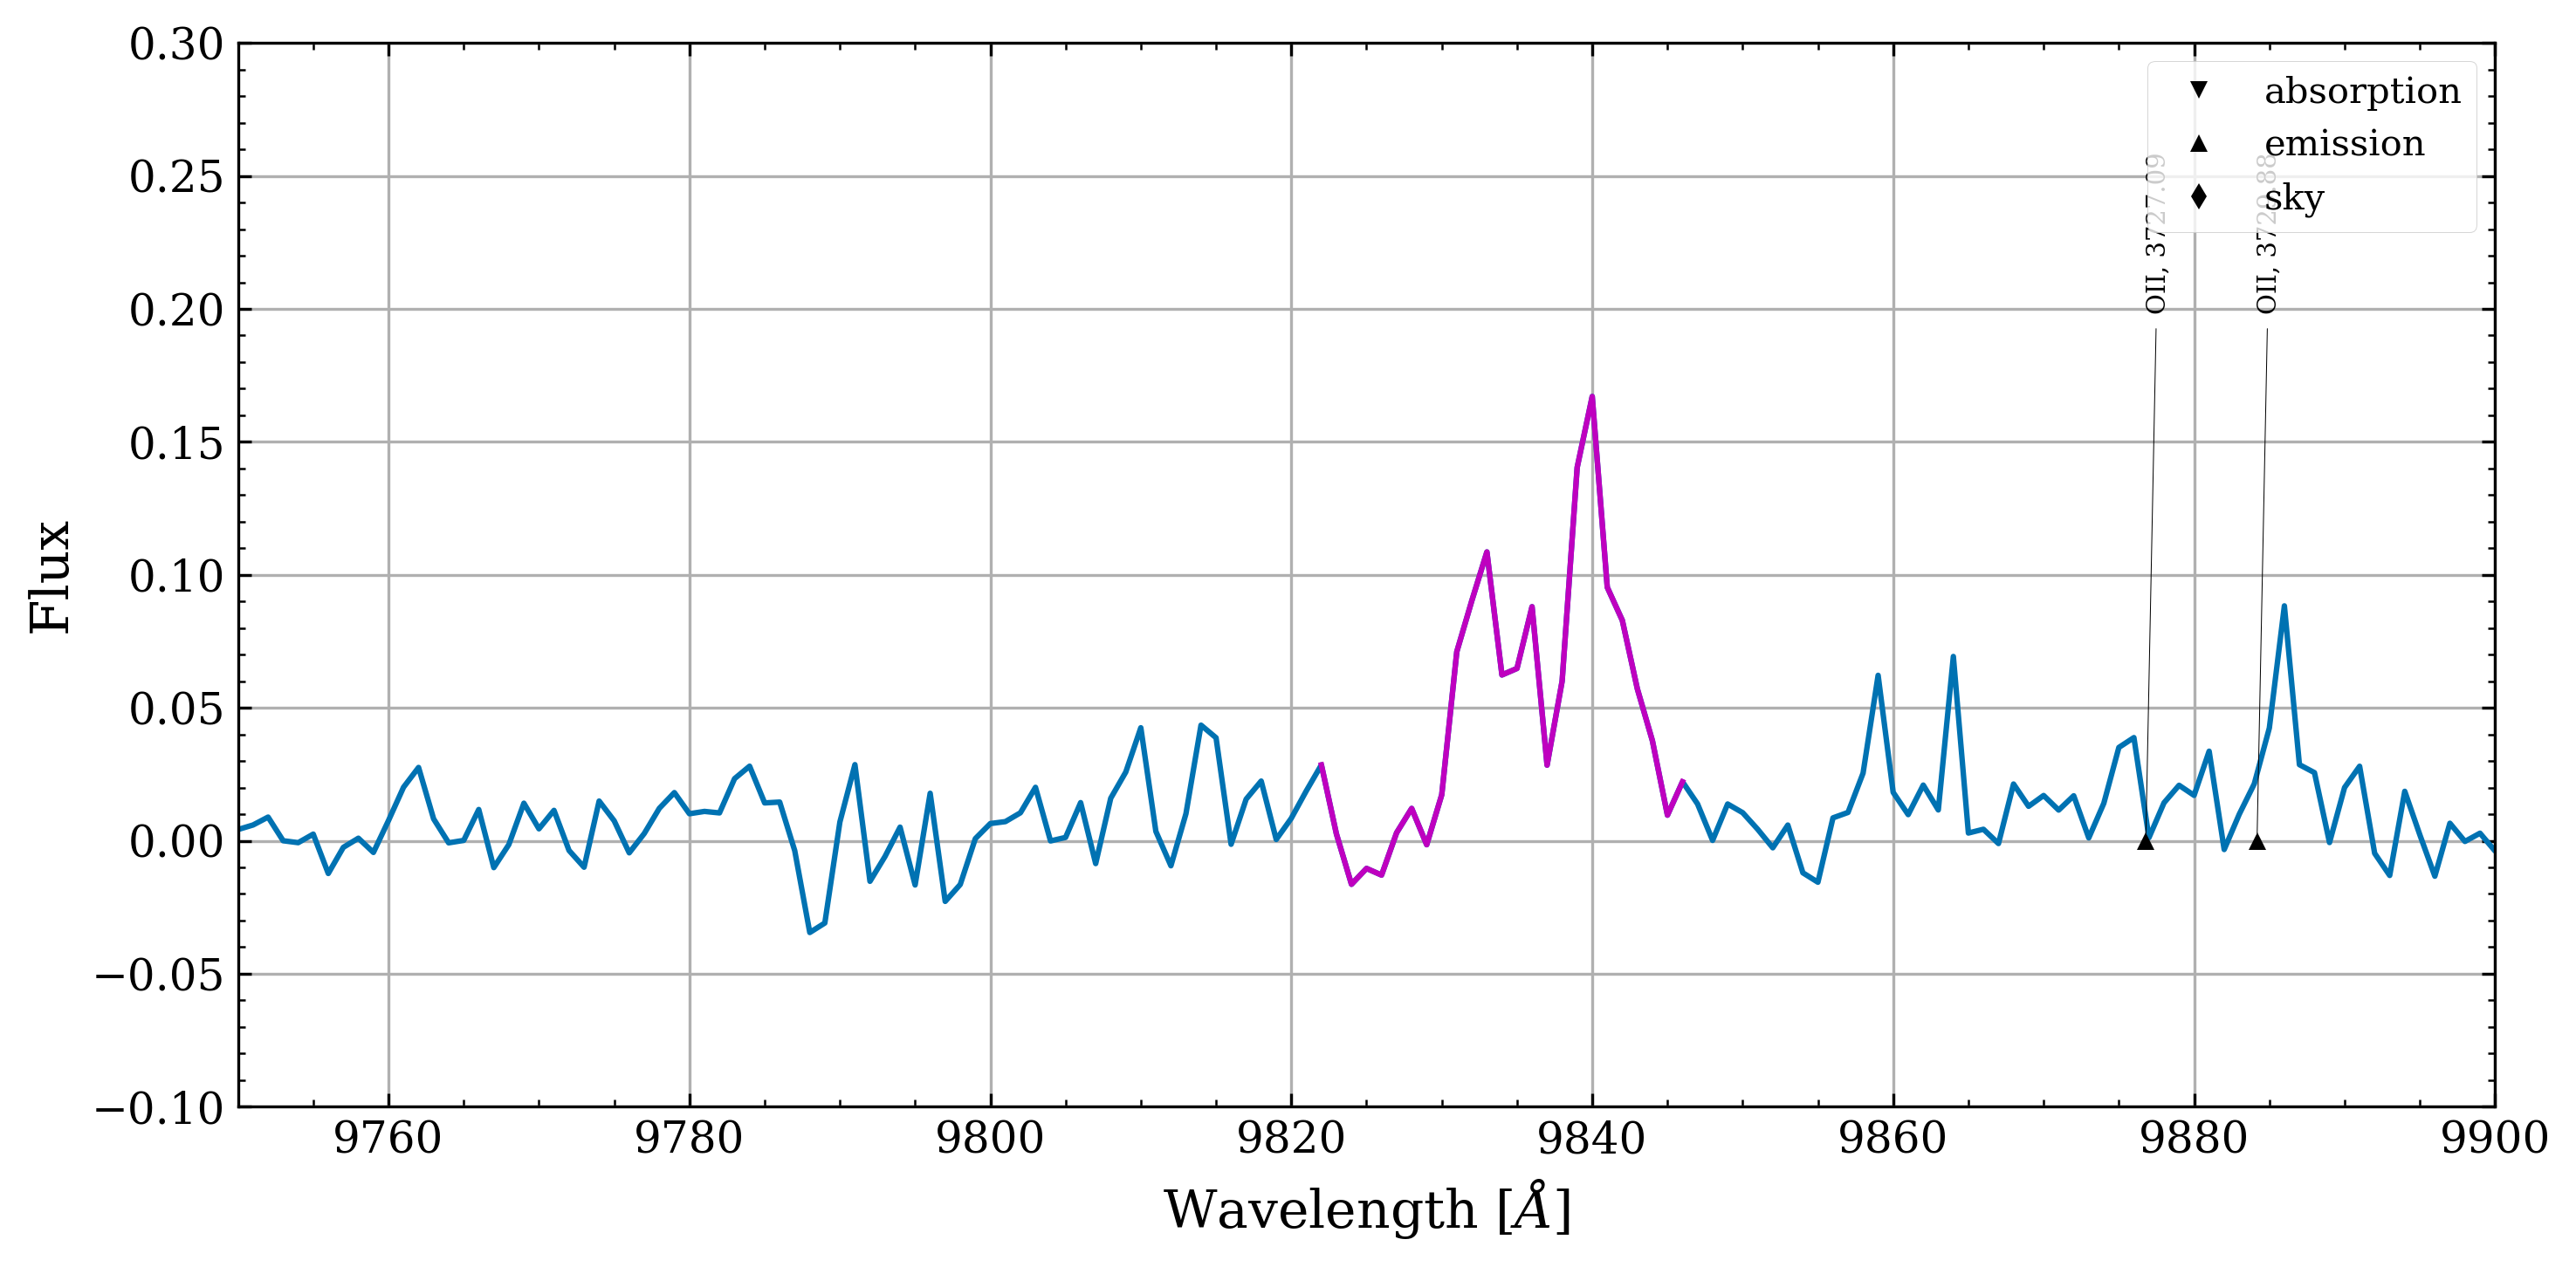

In [9]:
# play with matching up the lines!

zguess = 1.65 ## use the photo-z as your guess if you have it!
#zguess = 1.6382 ## my best guess

fig = plt.figure(figsize=(10,5))
plt.plot(wav_obj, spec1d_obj)
plt.plot(wav_obj[72:97], spec1d_obj[72:97],'m')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')

plt.xlim(9750,9900)
plt.ylim(-0.1,0.3)

plt.plot(ab['lambda']*(1+zguess),0*np.ones_like(ab['lambda']),'kv',ms=5,label='absorption')
plt.plot(em['lambda']*(1+zguess),0*np.ones_like(em['lambda']),'k^',ms=5,label='emission')
plt.plot(sky['lambda']*(1+zguess),0*np.ones_like(sky['lambda']),'kd',ms=5,label='sky')

for i in range(len(lines['lambda'])):
    plt.annotate(str(lines['species'][i]+', '+str(lines['lambda'][i])),xy=(lines['lambda'][i]*(1+zguess), 0),\
                xytext=(lines['lambda'][i]*(1+zguess), 0.2),arrowprops=dict(arrowstyle="-",),size=7,rotation=90)
plt.legend()

## pypeit

In [10]:
d1 = Table.read('../wmmc01/pypeit_spec1d/'+obj_name+'_1dspec.txt',format='ascii')
d1

lambda,opt_counts,opt_sigma,sky_counts,box_lambda,box_counts,box_sigma,box_sky_counts
float64,float64,float64,float64,float64,float64,float64,float64
9401.799945310135,-0.1400417761470002,0.9613228196336819,-0.2345206345994998,9401.807946642663,-0.24931712370308512,1.4262036268059464,-0.5122578396956691
9403.947219620399,-1.4588787360838198,0.9922741145831818,0.21586386234697033,9403.958323986157,-2.2010424671714266,1.4873454491706146,0.4776272678806667
9406.094933030263,1.2560007938763986,1.1080144180295812,0.2159078496454806,9406.08920168852,0.4322089207158887,1.6656187723820628,0.47806264124612285
9408.232332220357,0.7711877967109858,1.310219605141191,0.10073336998890452,9408.248667885715,-0.9707739144431662,1.946736065788812,0.2216636763480206
9410.416582592037,0.2509114679540798,1.2658538904338115,0.20594620400257926,9410.423488169372,0.9839225262244772,1.9178517993074282,0.45719864274713357
9412.603159504331,0.5194762531273529,1.1615335203727897,0.6021338200333619,9412.580821745887,0.9926351851851023,1.7855640761266505,1.3255206080446276
9414.767944321557,-0.8979071971411969,1.3818168526590415,0.36909064418839244,9414.759805593225,-1.216260404365379,2.036720603888261,0.8216527364342259
9416.903570030505,0.05283370116783088,1.403071897771207,-0.3210581771963734,9416.885630086768,-0.6864089934889748,2.0730765991858013,-0.7117925926785853
9419.037806139837,-0.5844273925438109,1.0649241734167307,0.2704556809607009,9419.016370881232,-0.22267609976603298,1.5955666642202009,0.6008737458387254


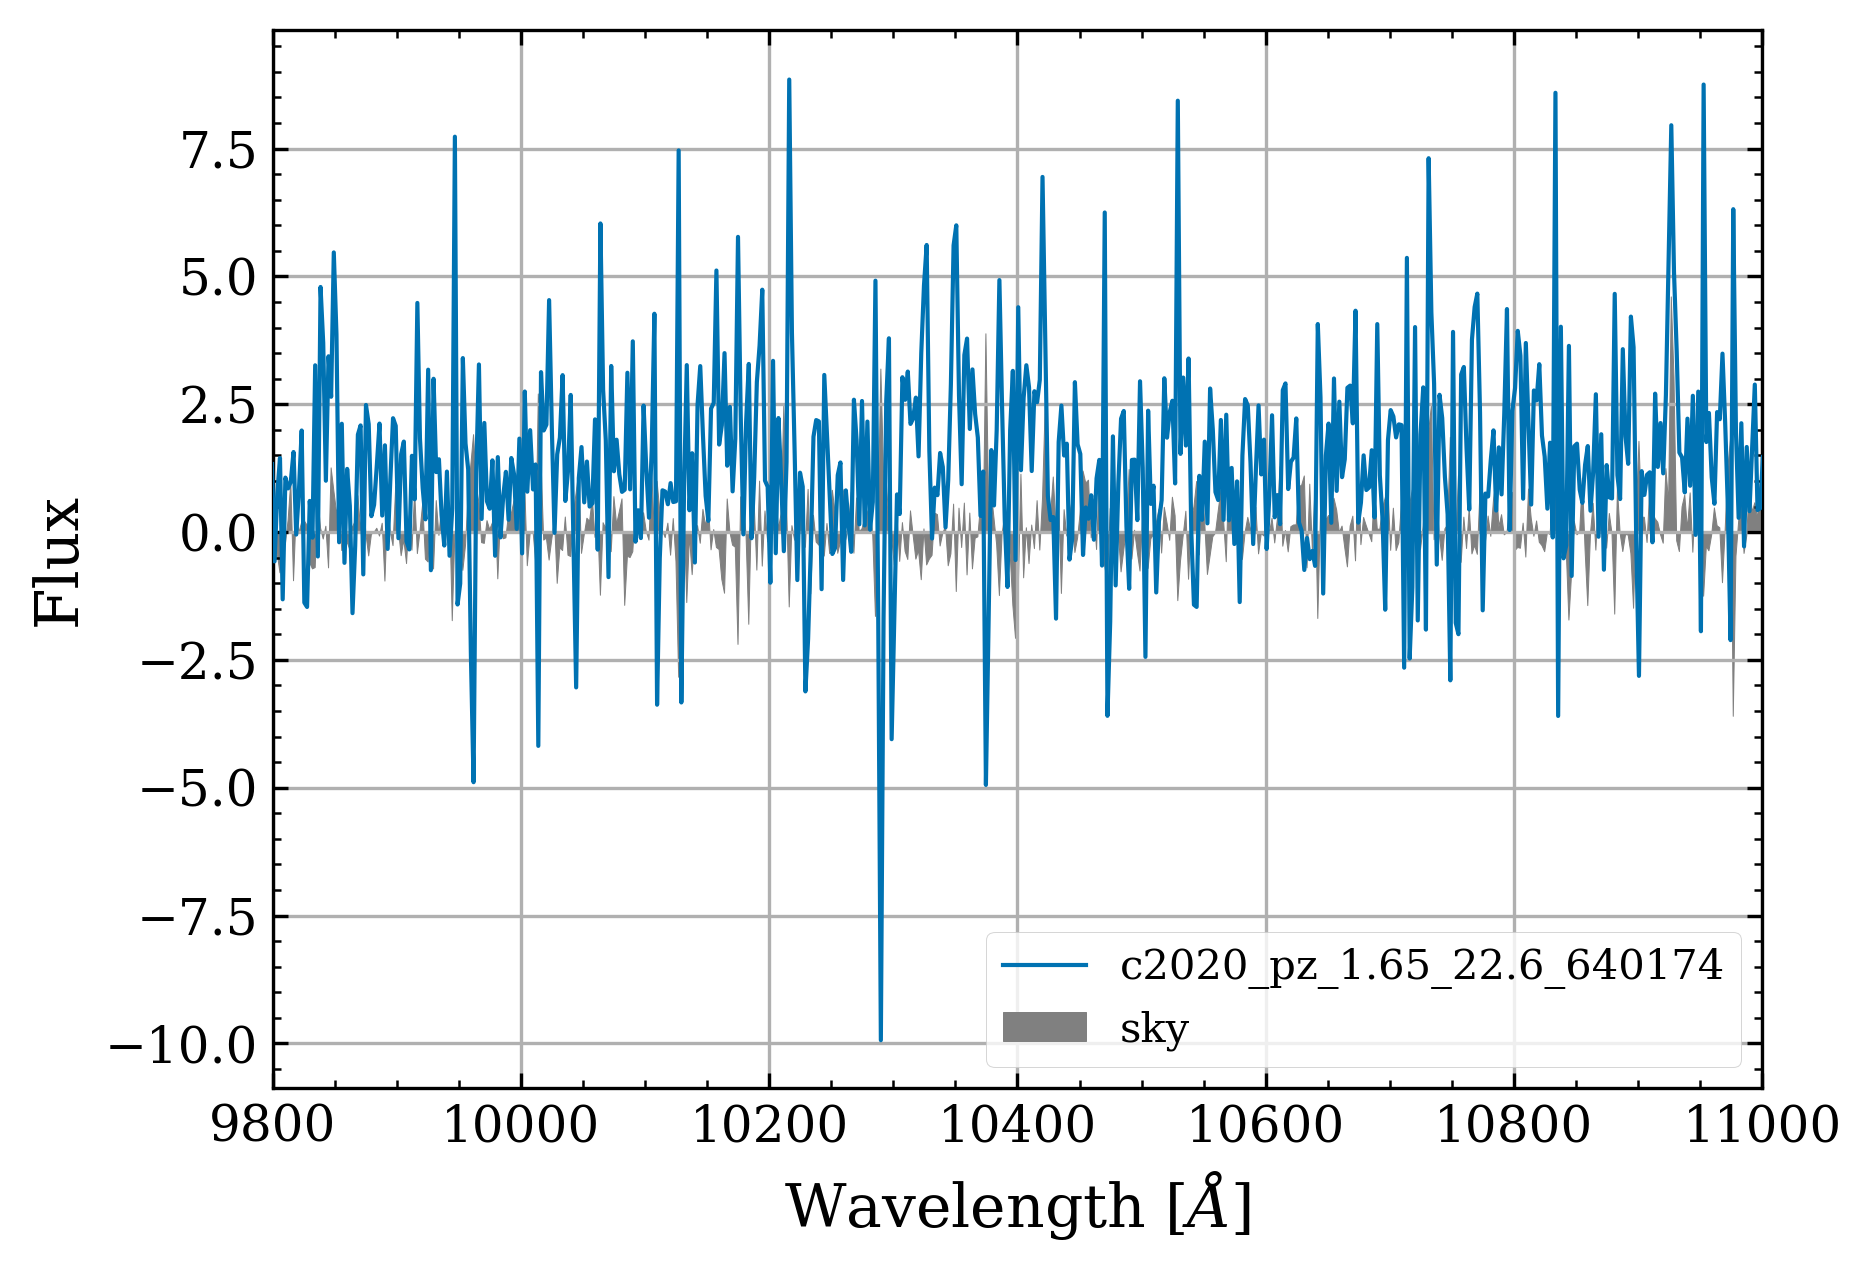

In [11]:
# plot the 1D spectra

plt.plot(d1['lambda'],d1['opt_counts'],zorder=10,lw=1,label=obj_name)
plt.fill_between(d1['lambda'],y1=d1['sky_counts'],y2=0,color='gray',label='sky')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.xlim(9800,11000) # change these to zoom in
plt.legend()

## mospy vs pypeit

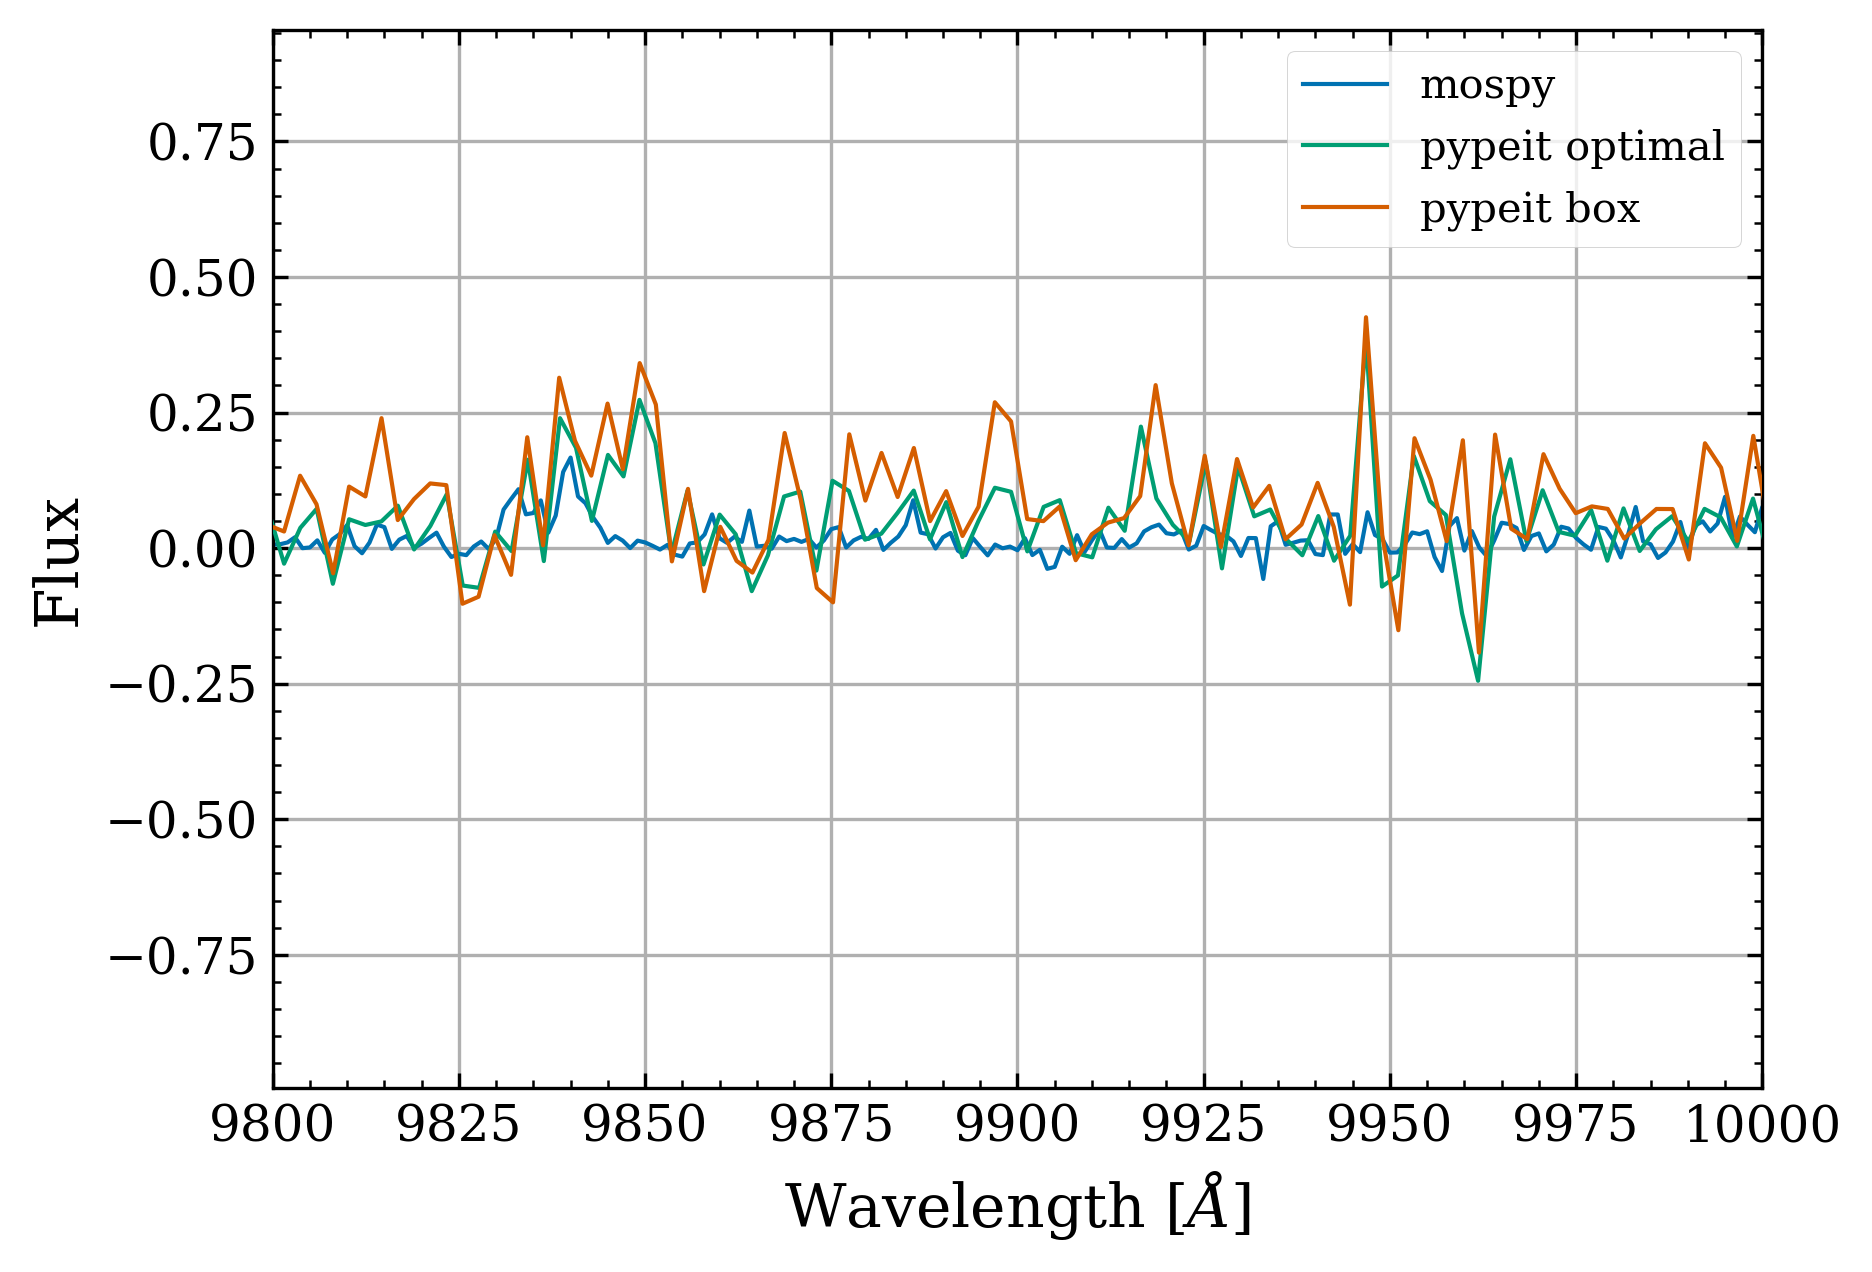

In [12]:
# plot the 1D spectra
# note: the flux scaling is pretty different, to compare more easily I've included a rough scaling factor (1/20)

## mospy

plt.plot(wav_obj, spec1d_obj, lw=1, label='mospy')
#plt.fill_between(wav_sky, y1=spec1d_sky, y2=0, color='gray', label='sky')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux')
plt.xlim(9800,10000) # change these to zoom in


## pypeit

plt.plot(d1['lambda'],d1['opt_counts']/20,zorder=10,lw=1,label='pypeit optimal')
plt.plot(d1['box_lambda'],d1['box_counts']/20,zorder=10,lw=1,label='pypeit box')
#plt.fill_between(d1['lambda'],y1=d1['sky_counts'],y2=0,color='gray',label='sky')
plt.legend()